In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Define Path to Orginal Execel Sheet and Output Directory
excel_path = 'data/elshafei.xlsx'
output_dir = 'data/elshafei_data_cleaned'
Path(output_dir).mkdir(exist_ok=True)

In [6]:
# Load All Sheetnames Present in Excel Sheet
sheet_names = pd.ExcelFile(excel_path).sheet_names

# Original Column Names
a_cols = ['ax', 'ay', 'az']
g_cols = ['gx', 'gy', 'gz']

# New Column Names
acc_cols = ['acc_x', 'acc_y', 'acc_z']
gyr_cols = ['gyr_x', 'gyr_y', 'gyr_z']

# Mapping for Renaming
rename_dict = dict(zip(a_cols + g_cols, acc_cols + gyr_cols))

# Define What Columns Need to be in CSVs
required_cols =  ['time', 'period'] + acc_cols + gyr_cols

In [7]:
df = pd.read_excel(excel_path, sheet_name=sheet_names[0])
df

,No. Participant,Age,Hight,Weight,No. Entries,bpm,Time(min.),Reps
0,Min,29,170,85,90512.0,0.7,20.0,4.0
1,Max,36,178,97,140035.0,1.9,45.0,5.0
2,Avgerage,33,176.5,95.7,115273.5,1.3,32.5,4.5
3,Est. Total (LR),-,-,-,2305470.0,-,650.0,1350.0


In [124]:
def format_df(df):
    df.columns = [col.strip() for col in df.columns]

    # Check if 'Timestamp(us)' Column Exists
    if 'Timestamp(us)' not in df.columns:
        # if not, Fabricate It (Can Be Left Out Later)
        print('Adding timestamps')
        df['time'] = np.arange(df.shape[0]) / 50
    else:
        # if yes, convert to seconds
        df['time'] = df['Timestamp(us)'] * 1e-6
    
    df.rename(columns=rename_dict, inplace=True)

    # Normalize Accelerometer Values
    for c in acc_cols:
        if c in df.columns:
            df[c] /= 16384.0
    
    # Normalize Gyroscope Values
    for c in gyr_cols:
        if c in df.columns:
            df[c] /= 131.0

    # Drop rows with all na
    df = df[~df.drop('bpm', axis=1).isna().all(axis=1)]

    # Only Grab Required Columns
    cols = [col for col in required_cols if col in df.columns]
    df = df[cols]

    df = df[df['period'] > 0].reset_index().rename(columns={'index': 'og_index'})
    return df

def interpolate_100hz(df):
    # Interpolate to 100Hz from 50Hz
    df['fake_time'] = np.arange(df.shape[0]) / 50.0
    interp = interp1d(df.fake_time, df.acc_x, kind='cubic')
    t_100hz = np.arange(df.fake_time.iloc[0], df.fake_time.iloc[-1], 0.01)
    df = pd.DataFrame(dict(
        time=t_100hz,
        acc_x=interp1d(df.fake_time, df.acc_x, kind='cubic')(t_100hz),
        acc_y=interp1d(df.fake_time, df.acc_y, kind='cubic')(t_100hz),
        acc_z=interp1d(df.fake_time, df.acc_z, kind='cubic')(t_100hz),
        gyr_x=interp1d(df.fake_time, df.gyr_x, kind='cubic')(t_100hz),
        gyr_y=interp1d(df.fake_time, df.gyr_y, kind='cubic')(t_100hz),
        gyr_z=interp1d(df.fake_time, df.gyr_z, kind='cubic')(t_100hz),
        period=interp1d(df.fake_time, df.period, kind='nearest')(t_100hz).astype(int),
    ))
    return df

In [ ]:
# Go Through Each Sheet, Do Some Cleaning and Renaming, Write to CSVs
for sheet in sheet_names:
    if sheet.lower() == 'summary':
        continue

    df = pd.read_excel(excel_path, sheet_name=sheet)
    
    df = format_df(df)
    df = interpolate_100hz(df)

    output_path = os.path.join(output_dir, f"{sheet}_cleaned.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved Cleaned Data for Sheet '{sheet}' to {output_path}")

Adding timestamps
Saved Cleaned Data for Sheet 'P0' to data/elshafei_data_cleaned/P0_cleaned.csv
Adding timestamps
Saved Cleaned Data for Sheet 'P1' to data/elshafei_data_cleaned/P1_cleaned.csv
Adding timestamps
Saved Cleaned Data for Sheet 'P2' to data/elshafei_data_cleaned/P2_cleaned.csv
Saved Cleaned Data for Sheet 'P3' to data/elshafei_data_cleaned/P3_cleaned.csv
Saved Cleaned Data for Sheet 'P4' to data/elshafei_data_cleaned/P4_cleaned.csv
Saved Cleaned Data for Sheet 'P5' to data/elshafei_data_cleaned/P5_cleaned.csv


In [134]:
df = pd.read_excel(excel_path, sheet_name=sheet_names[4])
print(df.columns)
df = format_df(df)
df = interpolate_100hz(df)
(1 / (np.diff(df.time.values))).mean()

Index(['Timestamp(us)', ' yaw', ' pitch', ' roll', ' ax', ' ay', ' az', ' gx',
       ' gy', ' gz', ' mx', ' my', ' mz', 'bpm', 'period'],
      dtype='object')


np.float64(100.0)

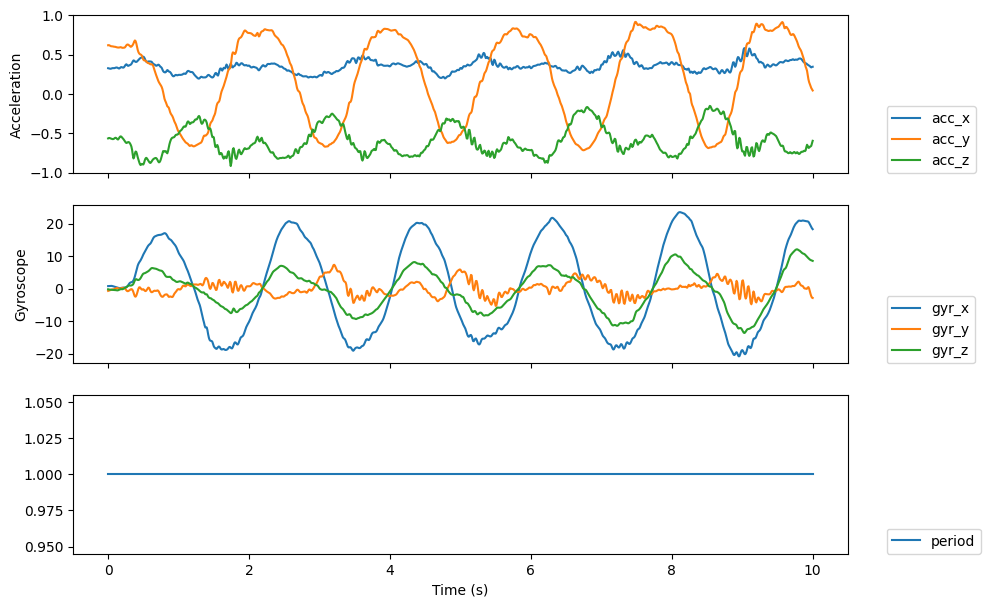

In [141]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

dfplot = df[df['time'].between(0,10)]
axes[0].plot(dfplot.time, dfplot[['acc_x', 'acc_y', 'acc_z']], label=['acc_x', 'acc_y', 'acc_z'])
axes[1].plot(dfplot.time, dfplot[['gyr_x', 'gyr_y', 'gyr_z']], label=['gyr_x', 'gyr_y', 'gyr_z'])
# axes[2].plot(dfplot.time, dfplot[['yaw', 'pitch', 'roll']], label=['yaw', 'pitch', 'roll'])
# axes[3].plot(dfplot.time, dfplot[['bpm']], label=['bpm'])
axes[2].plot(dfplot.time, dfplot['period'], label=['period'])

axes[0].set_ylabel('Acceleration')
axes[1].set_ylabel('Gyroscope')
# axes[2].set_ylabel('Position')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

# Segment sets / reps